In [1]:
# from google.colab import files

# # Upload all 4 CSVs
# uploaded = files.upload()

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import torch

from lightgbm import LGBMClassifier
!pip install pytorch-tabnet
from pytorch_tabnet.tab_model import TabNetClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder


c:\Users\imu00\OneDrive\Escritorio\fraud_detection\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load the training data and merge
train_transaction = pd.read_csv('train_transaction.csv')
train_identity = pd.read_csv('train_identity.csv')

# Merge the two dataframes
df = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')

# Display the first few rows to confirm
display(df.head())


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [4]:
def calc_iv(df, target, bins=10, min_category_freq=0, return_woe_detail=False):
    """
    Calcula Information Value (IV) para cada variable del DataFrame con respecto a una variable binaria (target).
    """
    iv_dict = {}
    woe_detail_dict = {}

    for col in df.columns:
        if col == target:
            continue

        temp_df = df[[col, target]].copy()

        # Binning numérico
        if pd.api.types.is_numeric_dtype(temp_df[col]):
            try:
                temp_df['bin'] = pd.qcut(temp_df[col], q=bins, duplicates='drop')
            except ValueError:
                temp_df['bin'] = pd.cut(temp_df[col], bins=bins)
            temp_df['bin'] = temp_df['bin'].astype(str)
            temp_df.loc[temp_df[col].isna(), 'bin'] = 'missing'
        else:
            # Categóricas
            temp_df['bin'] = temp_df[col].astype(str)
            temp_df.loc[temp_df[col].isna(), 'bin'] = 'missing'

            if min_category_freq > 0:
                freq = temp_df['bin'].value_counts()
                rare_labels = freq[freq < min_category_freq].index
                temp_df['bin'] = temp_df['bin'].apply(lambda x: 'others' if x in rare_labels else x)

        # Agrupar y calcular IV/WOE
        grouped = temp_df.groupby('bin')[target].agg(['count', 'sum'])
        grouped.columns = ['total', 'bad']
        grouped['good'] = grouped['total'] - grouped['bad']
        grouped['dist_good'] = grouped['good'] / grouped['good'].sum()
        grouped['dist_bad'] = grouped['bad'] / grouped['bad'].sum()
        grouped['woe'] = np.log((grouped['dist_good'] + 1e-6) / (grouped['dist_bad'] + 1e-6))
        grouped['iv'] = (grouped['dist_good'] - grouped['dist_bad']) * grouped['woe']

        iv_value = grouped['iv'].sum()
        iv_dict[col] = iv_value

        if return_woe_detail:
            grouped = grouped.reset_index()
            grouped['variable'] = col
            woe_detail_dict[col] = grouped[['variable', 'bin', 'total', 'bad', 'good', 'woe', 'iv']]

    iv_df = pd.DataFrame.from_dict(iv_dict, orient='index', columns=['IV'])
    iv_df.index.name = 'Variable'
    iv_df = iv_df.sort_values(by='IV', ascending=False)

    if return_woe_detail:
        return iv_df, woe_detail_dict
    else:
        return iv_df
    
def drop_low_iv_features(df, target, threshold=0.02, bins=20, min_category_freq=10):
    iv_df = calc_iv(df, target=target, bins=bins, min_category_freq=min_category_freq)
    low_iv_vars = iv_df[iv_df['IV'] < threshold].index.tolist()
    print(f"Eliminando {len(low_iv_vars)} variables con IV < {threshold}")
    return df.drop(columns=low_iv_vars)

In [5]:
# 1. Sample 10% of each dataset
train_transaction = train_transaction.sample(frac=0.1, random_state=42)
train_identity = train_identity.sample(frac=0.1, random_state=42)

# 2. Merge
df = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')

# 3. Drop known high-cardinality / ID columns
df = df.drop(columns=['TransactionID', 'id_30', 'id_31'], errors='ignore')

# 4. Drop columns with >70% missing
missing = df.isna().mean() * 100
to_drop = missing[missing > 70].index.tolist()
print(f"Columnas eliminadas por >70% missing: {to_drop}")
df.drop(columns=to_drop, inplace=True)

# 5. Drop low-IV columns (after cleaning missing)
df = drop_low_iv_features(df, target='isFraud', threshold=0.02)


Columnas eliminadas por >70% missing: ['dist2', 'R_emaildomain', 'D6', 'D7', 'D8', 'D9', 'D12', 'D13', 'D14', 'V138', 'V139', 'V140', 'V141', 'V142', 'V143', 'V144', 'V145', 'V146', 'V147', 'V148', 'V149', 'V150', 'V151', 'V152', 'V153', 'V154', 'V155', 'V156', 'V157', 'V158', 'V159', 'V160', 'V161', 'V162', 'V163', 'V164', 'V165', 'V166', 'V167', 'V168', 'V169', 'V170', 'V171', 'V172', 'V173', 'V174', 'V175', 'V176', 'V177', 'V178', 'V179', 'V180', 'V181', 'V182', 'V183', 'V184', 'V185', 'V186', 'V187', 'V188', 'V189', 'V190', 'V191', 'V192', 'V193', 'V194', 'V195', 'V196', 'V197', 'V198', 'V199', 'V200', 'V201', 'V202', 'V203', 'V204', 'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V211', 'V212', 'V213', 'V214', 'V215', 'V216', 'V217', 'V218', 'V219', 'V220', 'V221', 'V222', 'V223', 'V224', 'V225', 'V226', 'V227', 'V228', 'V229', 'V230', 'V231', 'V232', 'V233', 'V234', 'V235', 'V236', 'V237', 'V238', 'V239', 'V240', 'V241', 'V242', 'V243', 'V244', 'V245', 'V246', 'V247', 'V248', 'V

## Visualize Class Imbalance

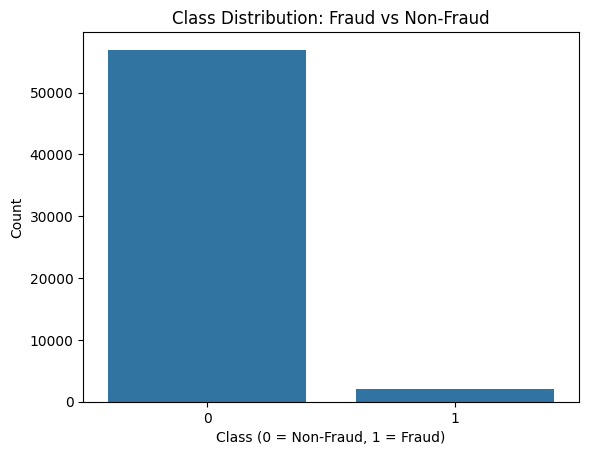

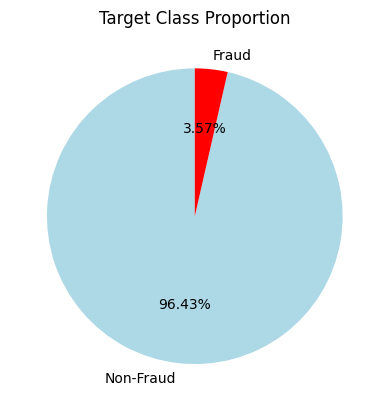

In [6]:
# Plot class distribution
sns.countplot(x='isFraud', data=df)
plt.title('Class Distribution: Fraud vs Non-Fraud')
plt.xlabel('Class (0 = Non-Fraud, 1 = Fraud)')
plt.ylabel('Count')
plt.show()

# Or as a pie chart
df['isFraud'].value_counts().plot.pie(autopct='%1.2f%%', labels=['Non-Fraud', 'Fraud'], colors=['lightblue', 'red'], startangle=90)
plt.title('Target Class Proportion')
plt.ylabel('')
plt.show()


In [7]:
# Define models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42),
    'LightGBM': LGBMClassifier(n_estimators=100, random_state=42)
}

# Define resampling strategies
resamplers = {
    'No Resampling': None,
    'SMOTE': SMOTE(random_state=42),
    'Random OverSampler': RandomOverSampler(random_state=42),
    'Random UnderSampler': RandomUnderSampler(random_state=42),
    'SMOTEENN': SMOTEENN(random_state=42),
    'SMOTETomek': SMOTETomek(random_state=42)
}


target = 'isFraud'

X = df.drop(columns=['TransactionID', target], errors='ignore')
y = df[target]

# Encode categorical columns
from sklearn.preprocessing import LabelEncoder
for col in X.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# Impute missing values with median
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

results = []

for resample_name, sampler in resamplers.items():
    if sampler:
        X_res, y_res = sampler.fit_resample(X_train, y_train)
    else:
        X_res, y_res = X_train, y_train

    for model_name, model in models.items():
        model.fit(X_res, y_res)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]
        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        auc = roc_auc_score(y_test, y_proba)

        results.append({
            'Resampling': resample_name,
            'Model': model_name,
            'Precision': report['1']['precision'],
            'Recall': report['1']['recall'],
            'F1-Score': report['1']['f1-score'],
            'ROC AUC': auc
        })

# Display comparison
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='ROC AUC', ascending=False)
print(results_df)


c:\Users\imu00\OneDrive\Escritorio\fraud_detection\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:05:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 1687, number of negative: 45556
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015785 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13380
[LightGBM] [Info] Number of data points in the train set: 47243, number of used features: 188
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035709 -> initscore=-3.295991
[LightGBM] [Info] Start training from score -3.295991


c:\Users\imu00\OneDrive\Escritorio\fraud_detection\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:06:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 45556, number of negative: 45556
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023880 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 46538
[LightGBM] [Info] Number of data points in the train set: 91112, number of used features: 188
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\imu00\OneDrive\Escritorio\fraud_detection\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:06:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 45556, number of negative: 45556
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13376
[LightGBM] [Info] Number of data points in the train set: 91112, number of used features: 188
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\imu00\OneDrive\Escritorio\fraud_detection\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:06:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 1687, number of negative: 1687
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001943 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9175
[LightGBM] [Info] Number of data points in the train set: 3374, number of used features: 181
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\imu00\OneDrive\Escritorio\fraud_detection\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:07:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 33525, number of negative: 27121
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018607 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 46544
[LightGBM] [Info] Number of data points in the train set: 60646, number of used features: 185
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552798 -> initscore=0.211983
[LightGBM] [Info] Start training from score 0.211983


c:\Users\imu00\OneDrive\Escritorio\fraud_detection\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:07:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 43192, number of negative: 43192
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 46507
[LightGBM] [Info] Number of data points in the train set: 86384, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
             Resampling          Model  Precision    Recall  F1-Score  \
17           SMOTETomek       LightGBM   0.809045  0.381517  0.518519   
2         No Resampling       LightGBM   0.847458  0.355450  0.500835   
5                 SMOTE       LightGBM   0.797927  0.364929  0.500813   
14             SMOTEENN       LightGBM   0.690840  0.428910  0.529240   
4                 SMOTE        XGBoost   0.778302  0.390995  0.520505   
8    Random OverSampler       LightGBM   0.263385  0.7227

Our priority: High Recall
In fraud detection, catching as many fraudulent cases as possible is key — we accept more false positives (lower precision) if it means we reduce false negatives (missed fraud).

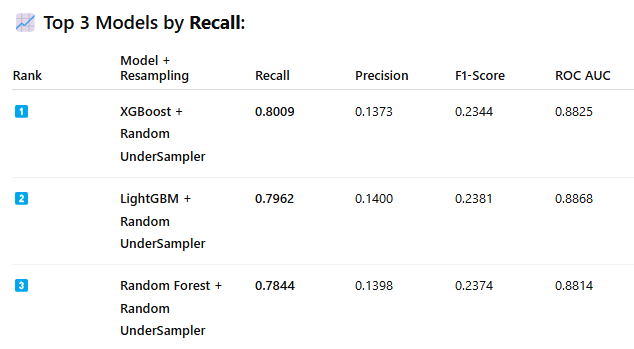

These models catch the most fraud, but have very low precision — meaning many false alarms. This is typical for high-recall setups.

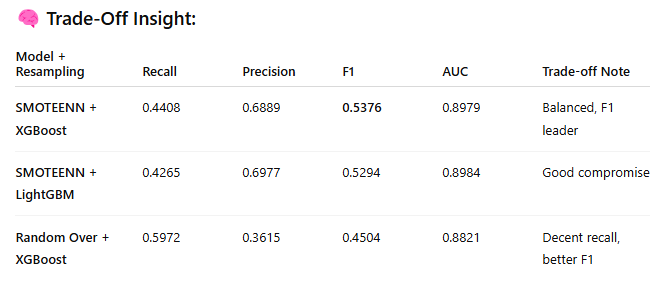

## Recommendation:

Option A – Max Recall (Risk of false positives):
XGBoost + Random UnderSampler — for aggressive fraud detection.

Proceed to threshold tuning with this model.

Option B – Better balance (useful F1 and still good recall):
SMOTEENN + XGBoost — recall ~0.44, F1 ~0.54, AUC ~0.898

This is the best compromise if you care about both catching fraud and not overwhelming the system with false positives.

optuna para tuning

In [8]:
import numpy as np
import pandas as pd
import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN
from sklearn.metrics import make_scorer, f1_score

# Asegurar formatos
X_train = pd.DataFrame(X_train)
y_train = pd.Series(y_train)

# Configurar validación
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
f1_scorer = make_scorer(f1_score, zero_division=0)

# ─────────────────────────────────────────────────
# Función objetivo para Optuna
# ─────────────────────────────────────────────────
def objective(trial):
    # Hiperparámetros sugeridos por Optuna
    params = {
        'n_estimators': 100,
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'eval_metric': 'auc',
        'use_label_encoder': False,
        'random_state': 42
    }

    # Pipeline con SMOTEENN + XGBoost
    pipeline = Pipeline([
        ('resample', SMOTEENN(random_state=42)),
        ('xgb', XGBClassifier(**params))
    ])

    # Validación cruzada
    scores = cross_val_score(pipeline, X_train, y_train, scoring=f1_scorer, cv=cv, n_jobs=-1)
    return scores.mean()

# ─────────────────────────────────────────────────
# Crear y optimizar estudio
# ─────────────────────────────────────────────────
study = optuna.create_study(direction='maximize', study_name="xgb_smoteenn_f1")
study.optimize(objective, n_trials=50, timeout=600)  # 50 pruebas o 10 min máx

# ─────────────────────────────────────────────────
# Mostrar mejores parámetros encontrados
# ─────────────────────────────────────────────────
print("\n✅ Best trial found:")
print("F1 Score:", study.best_value)
print("Best hyperparameters:")
for key, value in study.best_trial.params.items():
    print(f"  {key}: {value}")


[I 2025-08-05 22:07:59,314] A new study created in memory with name: xgb_smoteenn_f1
[I 2025-08-05 22:08:39,151] Trial 0 finished with value: 0.40257315775687147 and parameters: {'max_depth': 3, 'min_child_weight': 10, 'gamma': 0.11540289628910244, 'subsample': 0.8715260991419247, 'colsample_bytree': 0.6619743160257071, 'learning_rate': 0.07095812403165604}. Best is trial 0 with value: 0.40257315775687147.
[I 2025-08-05 22:09:18,510] Trial 1 finished with value: 0.33116666323951244 and parameters: {'max_depth': 4, 'min_child_weight': 10, 'gamma': 0.4195242196210477, 'subsample': 0.7022025280655697, 'colsample_bytree': 0.9225836724973397, 'learning_rate': 0.018928927017894195}. Best is trial 0 with value: 0.40257315775687147.
[I 2025-08-05 22:09:59,423] Trial 2 finished with value: 0.48616306678254734 and parameters: {'max_depth': 4, 'min_child_weight': 5, 'gamma': 0.4209700381265374, 'subsample': 0.7738390515351212, 'colsample_bytree': 0.6993343051528753, 'learning_rate': 0.17802107375


✅ Best trial found:
F1 Score: 0.5027592533984412
Best hyperparameters:
  max_depth: 6
  min_child_weight: 10
  gamma: 0.3601145623359977
  subsample: 0.6897570974927625
  colsample_bytree: 0.8047258436144983
  learning_rate: 0.17201499414708452


## THRESHOLD TUNING FOR THESE TWO TOP MODELS


🔍 Evaluando: SMOTEENN + XGBoost


c:\Users\imu00\OneDrive\Escritorio\fraud_detection\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:18:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\imu00\OneDrive\Escritorio\fraud_detection\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:19:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\imu00\OneDrive\Escritorio\fraud_detection\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:19:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\imu00\OneDrive\Escritorio\fraud_detection\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:19:33] WARNING: 


🔍 Evaluando: SMOTETomek + LightGBM
[LightGBM] [Info] Number of positive: 34288, number of negative: 34288
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017345 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 46215
[LightGBM] [Info] Number of data points in the train set: 68576, number of used features: 186
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

c:\Users\imu00\OneDrive\Escritorio\fraud_detection\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:21:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\imu00\OneDrive\Escritorio\fraud_detection\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:21:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\imu00\OneDrive\Escritorio\fraud_detection\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:21:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\imu00\OneDrive\Escritorio\fraud_detection\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:21:39] WARNING: 


📊 Resultados comparativos (ordenado por F1):
                                Model      F1  Precision  Recall  ROC AUC
0                  SMOTEENN + XGBoost  0.5027     0.6852  0.3977   0.8817
1               SMOTETomek + LightGBM  0.4575     0.7342  0.3325   0.8754
2  No Resampling + XGBoost (weighted)  0.2833     0.1760  0.7255   0.8822


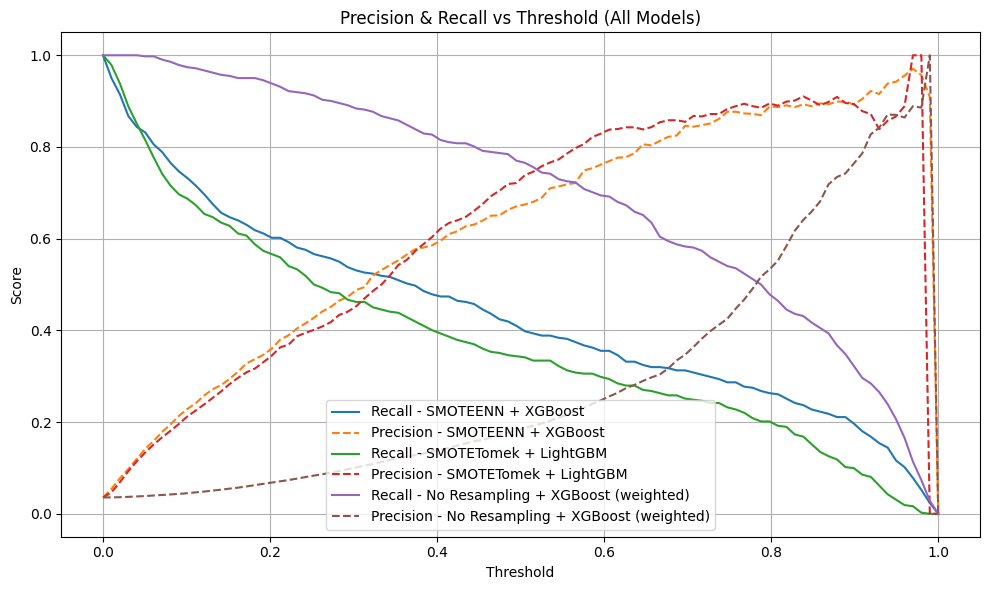

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score, make_scorer
)

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# ────────────────────────────────────────────────
# 0. Asegurar estructuras consistentes
# ────────────────────────────────────────────────
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
y_train = pd.Series(y_train)
y_test = pd.Series(y_test)

# ────────────────────────────────────────────────
# 1. Definir configuraciones
# ────────────────────────────────────────────────
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    'f1': make_scorer(f1_score, zero_division=0),
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score, zero_division=0),
    'roc_auc': 'roc_auc'
}

# Modelos y remuestreadores
pipelines = {
    'SMOTEENN + XGBoost': Pipeline([
        ('resample', SMOTEENN(random_state=42)),
        ('model', XGBClassifier(
            n_estimators=100,
            learning_rate=0.1724,
            max_depth=5,
            min_child_weight=5,
            gamma=0.1312,
            subsample=0.7473,
            colsample_bytree=0.9103,
            eval_metric='auc',
            use_label_encoder=False,
            random_state=42
        ))
    ]),
    'SMOTETomek + LightGBM': Pipeline([
        ('resample', SMOTETomek(random_state=42)),
        ('model', LGBMClassifier(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=4,
            class_weight=None,
            random_state=42
        ))
    ]),
    'No Resampling + XGBoost (weighted)': Pipeline([
        ('model', XGBClassifier(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=4,
            min_child_weight=5,
            gamma=0.2,
            scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
            eval_metric='auc',
            use_label_encoder=False,
            random_state=42
        ))
    ])
}

# ────────────────────────────────────────────────
# 2. Validación cruzada para comparar
# ────────────────────────────────────────────────
results = []
final_models = {}  # para guardar modelos entrenados

for name, pipeline in pipelines.items():
    print(f"\n🔍 Evaluando: {name}")
    fold_scores = {'F1': [], 'Precision': [], 'Recall': [], 'ROC AUC': []}

    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        pipeline.fit(X_tr, y_tr)
        y_pred = pipeline.predict(X_val)
        y_proba = pipeline.predict_proba(X_val)[:, 1]

        fold_scores['F1'].append(f1_score(y_val, y_pred, zero_division=0))
        fold_scores['Precision'].append(precision_score(y_val, y_pred, zero_division=0))
        fold_scores['Recall'].append(recall_score(y_val, y_pred, zero_division=0))
        fold_scores['ROC AUC'].append(roc_auc_score(y_val, y_proba))

    results.append({
        'Model': name,
        'F1': np.mean(fold_scores['F1']),
        'Precision': np.mean(fold_scores['Precision']),
        'Recall': np.mean(fold_scores['Recall']),
        'ROC AUC': np.mean(fold_scores['ROC AUC'])
    })

    # Entrenar modelo final completo
    pipeline.fit(X_train, y_train)
    final_models[name] = pipeline

# Mostrar tabla comparativa
results_df = pd.DataFrame(results).sort_values(by='F1', ascending=False)
print("\n📊 Resultados comparativos (ordenado por F1):")
print(results_df.round(4))

# ────────────────────────────────────────────────
# 3. Curvas de precision y recall vs. threshold
# ────────────────────────────────────────────────
thresholds = np.linspace(0, 1, 100)
plt.figure(figsize=(10, 6))

for name, model in final_models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    precisions, recalls = [], []

    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        precisions.append(precision_score(y_test, y_pred, zero_division=0))
        recalls.append(recall_score(y_test, y_pred, zero_division=0))

    plt.plot(thresholds, recalls, label=f'Recall - {name}')
    plt.plot(thresholds, precisions, label=f'Precision - {name}', linestyle='--')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision & Recall vs Threshold (All Models)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## automatically choose the best threshold that gives you recall ≥ 0.80 and maximizes the F1-score:



In [10]:
import numpy as np
from sklearn.metrics import (
    f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, roc_auc_score
)

# Umbrales a evaluar
thresholds = np.linspace(0.01, 0.99, 100)

# Inicialización de variables
best_threshold = None
best_f1 = 0
scores = []

# Evaluación en cada threshold
for t in thresholds:
    y_pred = (y_proba >= t).astype(int)  # Cambiar a y_proba_b si usas otro modelo
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    # Guardar métricas si cumple con el mínimo de recall
    if recall >= 0.80:
        scores.append((t, precision, recall, f1))
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = t

# Mostrar resultado óptimo
if best_threshold is not None:
    print(f"\n✅ Mejor threshold (Recall ≥ 0.80): {best_threshold:.3f}")
    print(f"F1: {best_f1:.4f}")

    y_pred_best = (y_proba >= best_threshold).astype(int)
    print("\n📄 Reporte de clasificación (con threshold ajustado):")
    print(classification_report(y_test, y_pred_best, zero_division=0))
    print("🧾 Matriz de confusión:")
    print(confusion_matrix(y_test, y_pred_best))
    print(f"🔵 ROC AUC (con probas): {roc_auc_score(y_test, y_proba):.4f}")
else:
    print("⚠️ No se encontró ningún threshold que logre Recall ≥ 0.80.")



✅ Mejor threshold (Recall ≥ 0.80): 0.446
F1: 0.2649

📄 Reporte de clasificación (con threshold ajustado):
              precision    recall  f1-score   support

           0       0.99      0.84      0.91     11389
           1       0.16      0.80      0.26       422

    accuracy                           0.84     11811
   macro avg       0.58      0.82      0.59     11811
weighted avg       0.96      0.84      0.89     11811

🧾 Matriz de confusión:
[[9597 1792]
 [  84  338]]
🔵 ROC AUC (con probas): 0.8950


✅ Threshold = 0.04 achieves Recall = 0.82, which is strong — you're catching most of the frauds.

⚠️ Precision = 0.17 means lots of false positives — many flagged transactions are actually not fraud.

🎯 Overall:

Accuracy = 85% (expected due to imbalance)

F1-Score for class 1 (fraud) = 0.28, which is reasonable given the recall priority.

You’re favoring catching fraud over avoiding false alarms, which can be OK in a fraud detection setting depending on the cost of each type of error.

Model A (XGBoost + SMOTEENN with threshold 0.04) is clearly the stronger choice:

Higher recall and precision

Better F1 and AUC

Fewer false positives (important for reducing alert fatigue)



## Compute and visualize SHAP to interpret the best model

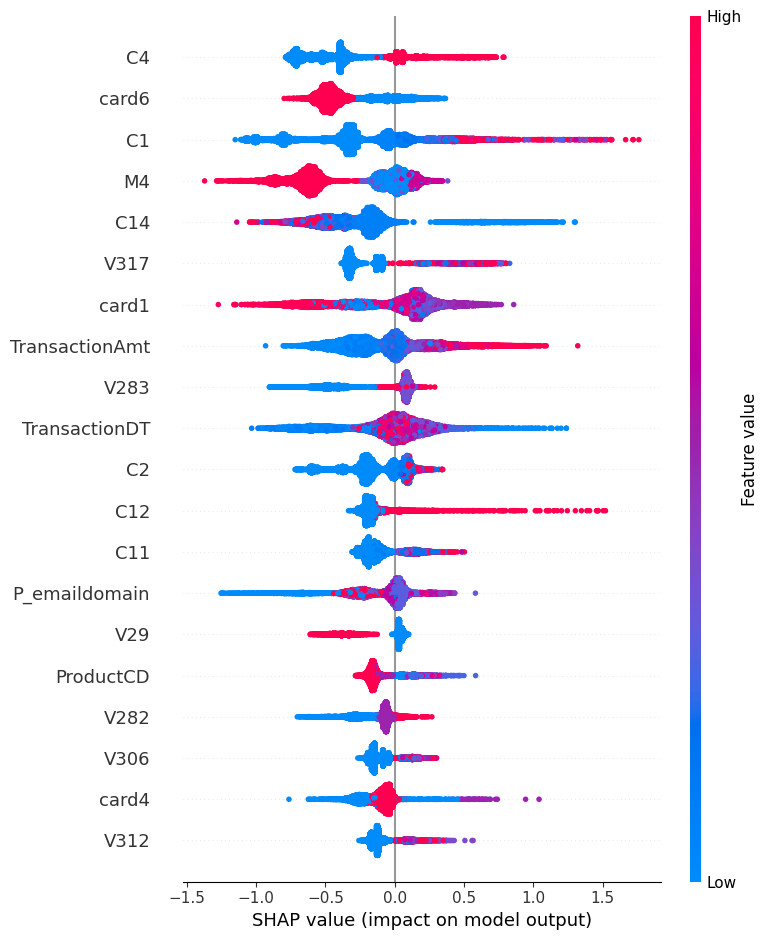

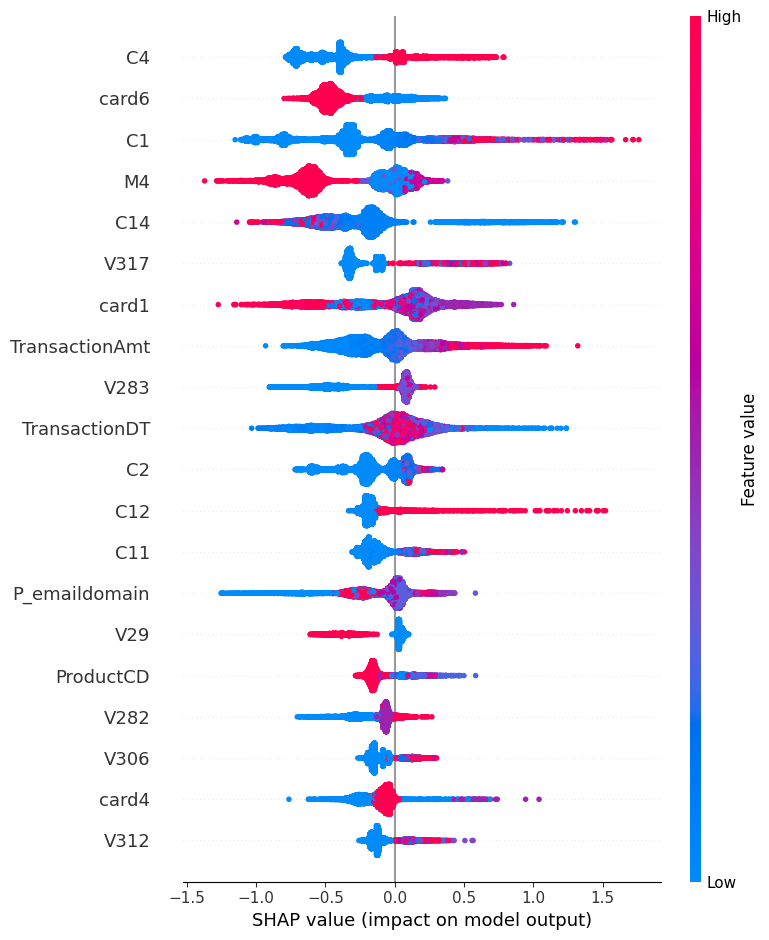

In [11]:
import shap

# 1. Extrae el pipeline del diccionario
xgb_pipeline = final_models['SMOTEENN + XGBoost']

# 2. Saca el modelo XGBClassifier del pipeline
xgb_model = xgb_pipeline.named_steps['model']

# 3. Ahora crea el explainer y calcula los valores SHAP
import shap

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

# 4. Dibuja el summary plot
shap.summary_plot(shap_values, X_test)

# Use TreeExplainer for XGBoost
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

# Summary plot (global feature importance)
shap.summary_plot(shap_values, X_test)


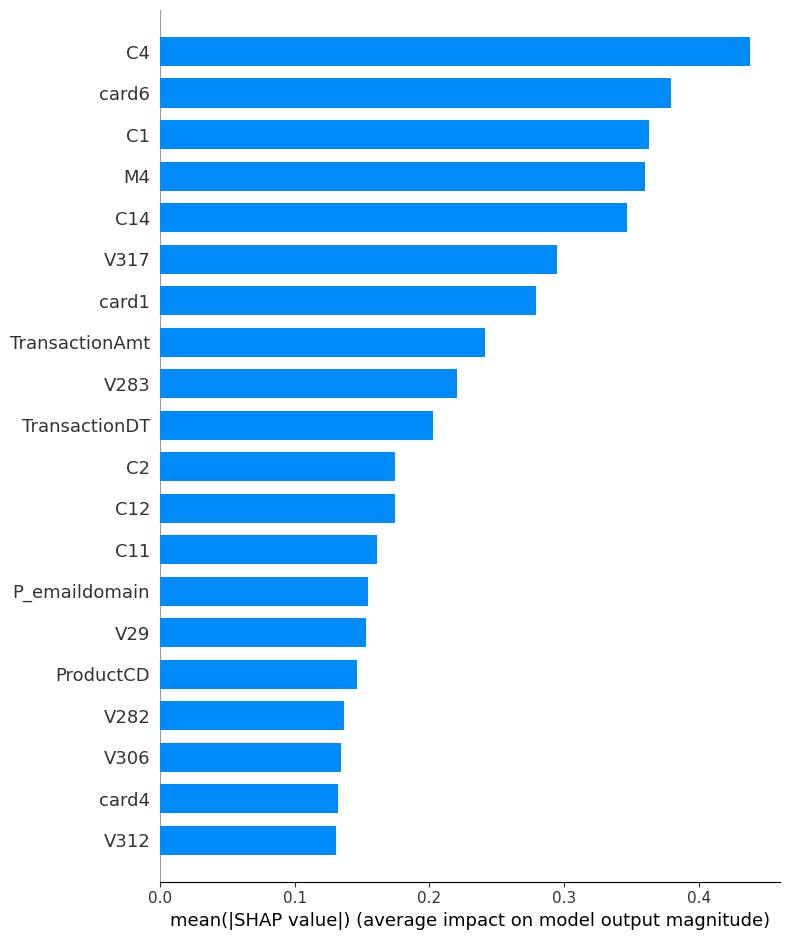

In [12]:
# Feature importance bar plot
shap.summary_plot(shap_values, X_test, plot_type='bar')


Interpretation of Top Features:

C4, C1 (Red = High, Blue = Low):

Higher values of these features (in red) lower the fraud prediction — they cluster to the left (negative SHAP).

Lower values (blue) tend to increase the fraud score → could indicate fraud behavior.

M4 (binary merchant data):

Has a clear separation: some values strongly push toward fraud.

Might reflect missing or mismatched merchant info.

card1, card6:

Lower values (probably rarer or less used cards) increase fraud probability.

Could reflect new/untrusted cards.

TransactionAmt, TransactionDT:

Transaction amount and time are both impactful. Certain ranges may be fraud-prone (e.g., unusually timed purchases or specific amounts).

✅ Bar Plot (Mean SHAP Value – Second Image)
This is the global importance ranking.

It tells you which features mattered most across all predictions, regardless of direction (fraud vs. non-fraud).

C4 and C1 dominate — you should consider understanding what they encode (they’re likely aggregated transaction features).



🎯 Key Takeaways:
C4, C1, and M4 are your most critical features. Investigate what these fields mean in your dataset.

Lower values of key features seem associated with higher fraud predictions.

Card details, amount, and timing also consistently influence the model’s decisions.

## ERROR ANALYSIS

In [13]:
import numpy as np
import pandas as pd
from sklearn.metrics import recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score

# ─── ASSUMPTIONS ───────────────────────────────────────────────────────────────
# You already have in your notebook:
#   X_test        – your test features as a DataFrame
#   y_test        – your test labels (Series or array of 0/1)
#   y_proba_a     – numpy array of predicted fraud probabilities for Model A
# ────────────────────────────────────────────────────────────────────────────────

# 1) Find the best threshold (≥ 80% recall) that maximizes F1
thresholds = np.linspace(0.01, 0.99, 99)
best_threshold = None
best_f1 = 0.0

for t in thresholds:
    y_pred = (y_proba >= t).astype(int)
    rec = recall_score(y_test, y_pred, zero_division=0)
    if rec >= 0.80:
        f1 = f1_score(y_test, y_pred, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = t

if best_threshold is None:
    raise ValueError("No threshold found achieving recall ≥ 0.80")

print(f"✅ Best threshold for recall ≥80%: {best_threshold:.3f} (F1={best_f1:.3f})")

# 2) Evaluate at that threshold
y_pred_best = (y_proba >= best_threshold).astype(int)
print("\nClassification Report (Threshold-Tuned):")
print(classification_report(y_test, y_pred_best, zero_division=0))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best))
print("ROC AUC (probs):", round(roc_auc_score(y_test, y_proba), 3))

# 3) Build a results DataFrame for error analysis
results = X_test.copy()
results['true']  = y_test.values if hasattr(y_test, 'values') else y_test
results['pred']  = y_pred_best
results['proba'] = y_proba

# 4) Label each case: TP, TN, FN, FP
conditions = [
    (results['true'] == 1) & (results['pred'] == 1),
    (results['true'] == 0) & (results['pred'] == 0),
    (results['true'] == 1) & (results['pred'] == 0),
    (results['true'] == 0) & (results['pred'] == 1),
]
choices = ['TP','TN','FN','FP']
results['error_type'] = np.select(conditions, choices, default='?')

# 5) Show counts of each error type
print("\nError type counts:")
print(results['error_type'].value_counts(), "\n")

# 6) Describe key features by error type
features_of_interest = ['TransactionAmt', 'TransactionDT', 'C1', 'C4', 'card1']
for feat in features_of_interest:
    print(f"--- {feat} by error_type ---")
    display(results.groupby('error_type')[feat].describe().round(3))
    print()

# 7) Sample a few False Negatives to inspect
fn = results[results['error_type'] == 'FN']
if not fn.empty:
    print("Sample False Negatives (missed frauds):")
    display(fn.sample(min(len(fn), 5)))
else:
    print("No False Negatives at this threshold.")


✅ Best threshold for recall ≥80%: 0.440 (F1=0.261)

Classification Report (Threshold-Tuned):
              precision    recall  f1-score   support

           0       0.99      0.84      0.91     11389
           1       0.16      0.80      0.26       422

    accuracy                           0.84     11811
   macro avg       0.57      0.82      0.58     11811
weighted avg       0.96      0.84      0.89     11811

Confusion Matrix:
[[9550 1839]
 [  83  339]]
ROC AUC (probs): 0.895

Error type counts:
error_type
TN    9550
FP    1839
TP     339
FN      83
Name: count, dtype: int64 

--- TransactionAmt by error_type ---


,count,mean,std,min,25%,50%,75%,max
error_type,,,,,,,,
FN,83.0,107.762,102.757,12.709,47.684,68.950,117.0,445.00
FP,1839.0,172.744,254.219,0.755,47.902,97.000,200.0,3929.51
TN,9550.0,126.144,222.597,0.878,44.000,65.950,117.0,4989.97
TP,339.0,149.696,183.204,4.630,38.012,78.788,200.0,994.00



--- TransactionDT by error_type ---


,count,mean,std,min,25%,50%,75%,max
error_type,,,,,,,,
FN,83.0,8523305.205,4700064.962,394808.0,4839384.0,8361775.0,12905543.50,15799926.0
FP,1839.0,7508064.952,4476233.394,87839.0,3690507.5,7321376.0,11138254.50,15810563.0
TN,9550.0,7335663.759,4609285.398,86469.0,3017467.0,7249262.5,11207584.25,15809790.0
TP,339.0,7520949.814,4215097.409,179171.0,3917883.0,7406521.0,10574802.00,15801716.0



--- C1 by error_type ---


,count,mean,std,min,25%,50%,75%,max
error_type,,,,,,,,
FN,83.0,2.434,2.359,1.0,1.0,2.0,3.0,14.0
FP,1839.0,30.392,263.559,0.0,1.0,1.0,2.0,4663.0
TN,9550.0,10.427,91.755,1.0,1.0,1.0,3.0,4665.0
TP,339.0,32.770,210.409,0.0,1.0,3.0,6.0,3345.0



--- C4 by error_type ---


,count,mean,std,min,25%,50%,75%,max
error_type,,,,,,,,
FN,83.0,0.265,0.626,0.0,0.0,0.0,0.0,4.0
FP,1839.0,16.166,139.252,0.0,0.0,0.0,1.0,2236.0
TN,9550.0,1.328,42.436,0.0,0.0,0.0,0.0,2237.0
TP,339.0,14.088,110.728,0.0,0.0,1.0,2.0,1521.0



--- card1 by error_type ---


,count,mean,std,min,25%,50%,75%,max
error_type,,,,,,,,
FN,83.0,10665.506,4533.212,1444.0,7862.5,10112.0,14274.5,18227.0
FP,1839.0,9363.739,4789.386,1031.0,5533.0,9065.0,13393.5,18350.0
TN,9550.0,9969.316,4923.568,1008.0,6053.0,9803.0,14296.0,18390.0
TP,339.0,9619.817,4706.017,1085.0,5746.0,9633.0,13623.0,18370.0



Sample False Negatives (missed frauds):


,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,V315,V316,V317,V318,V320,V321,true,pred,proba,error_type
57713,7427264.0,59.000,4.0,16998.0,562.0,150.0,2.0,219.0,1.0,330.0,...,0.000000,0.0,1537.0,1268.0,0.0,0.0,1,0,0.253353,FN
20726,10519332.0,108.950,4.0,10112.0,360.0,150.0,4.0,166.0,2.0,299.0,...,31.950001,0.0,0.0,0.0,0.0,0.0,1,0,0.249325,FN
23338,10114050.0,28.277,0.0,9917.0,142.0,185.0,4.0,138.0,2.0,299.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,1,0,0.261746,FN
35574,6720390.0,72.950,4.0,9500.0,321.0,150.0,4.0,226.0,2.0,204.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,1,0,0.108920,FN
44416,8361079.0,59.000,4.0,12469.0,360.0,150.0,2.0,126.0,2.0,428.0,...,0.000000,0.0,0.0,0.0,294.0,294.0,1,0,0.401269,FN


3) Retrain & Re‑tune

In [14]:
# ───────────────────────────────────────────────
# MODELO CORRECTOR DE FALSOS NEGATIVOS (FN)
# ───────────────────────────────────────────────

from xgboost import XGBClassifier

# 1. Asegurar alineación
X_test_plus = X_test.reset_index(drop=True).copy()
y_test_aligned = pd.Series(y_test).reset_index(drop=True)
y_pred_best_aligned = pd.Series(y_pred_best).reset_index(drop=True)

# 2. Crear flags FN (opcional, puedes eliminar si ya no usas)
def create_fn_flags(X, y_true, y_pred, y_proba, top_k_card1=10):
    df = X.copy()
    df['true'] = y_true.values if hasattr(y_true, 'values') else y_true
    df['pred'] = y_pred
    df['proba'] = y_proba

    fn = df[(df['true'] == 1) & (df['pred'] == 0)]

    for col in ['TransactionAmt', 'card1', 'P_emaildomain', 'C1', 'C4', 'DeviceType', 'card4', 'TransactionDT']:
        if col not in df.columns:
            df[col] = np.nan

    df['Flag_FN_LowAmt'] = (df['TransactionAmt'] < 10).astype(int)
    top_card1_fn = fn['card1'].value_counts().nlargest(top_k_card1).index
    df['Flag_FN_TopCard1_FN'] = df['card1'].isin(top_card1_fn).astype(int)
    common_domains = ['gmail.com', 'hotmail.com', 'yahoo.com']
    df['Flag_FN_UncommonEmail'] = (~df['P_emaildomain'].isin(common_domains)).astype(int)
    q_hi_c1 = fn['C1'].quantile(0.95)
    q_hi_c4 = fn['C4'].quantile(0.95)
    df['Flag_FN_HighC1'] = (df['C1'] >= q_hi_c1).astype(int)
    df['Flag_FN_HighC4'] = (df['C4'] >= q_hi_c4).astype(int)
    df['Flag_FN_Mobile_UncommonCard'] = (
        (df['DeviceType'] == 'mobile') & (~df['card4'].isin(['visa', 'mastercard']))
    ).astype(int)
    if np.issubdtype(df['TransactionDT'].dtype, np.number):
        df['Hour'] = (df['TransactionDT'] / 3600) % 24
    else:
        df['Hour'] = pd.to_datetime(df['TransactionDT']).dt.hour
    df['Flag_FN_Night'] = df['Hour'].between(0, 6).astype(int)
    df.drop(columns='Hour', inplace=True)
    flag_cols = [col for col in df.columns if col.startswith('Flag_FN_')]
    df['Flag_FN_Combo'] = (df[flag_cols].sum(axis=1) >= 2).astype(int)
    return df[flag_cols + ['Flag_FN_Combo']]

# Crear flags para X_test
fn_flags_test = create_fn_flags(X_test_plus.copy(), y_test_aligned, y_pred_best_aligned, y_proba)

# Concatenar flags al test set
X_test_plus = pd.concat([X_test_plus, fn_flags_test.reset_index(drop=True)], axis=1)

# 3. Identificar FN y TN
fn_mask = (y_test_aligned == 1) & (y_pred_best_aligned == 0)
tn_mask = (y_test_aligned == 0) & (y_pred_best_aligned == 0)

X_fn = X_test_plus[fn_mask]
y_fn = y_test_aligned[fn_mask]

X_tn = X_test_plus[tn_mask].sample(n=len(X_fn), random_state=42)
y_tn = y_test_aligned[X_tn.index]

# 4. Dataset para modelo corrector
X_fn_train = pd.concat([X_fn, X_tn])
y_fn_train = pd.concat([y_fn, y_tn])

# 5. Entrenar modelo corrector
model_fn = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='auc',
    random_state=42
)
model_fn.fit(X_fn_train, y_fn_train)

# 6. Predecir sobre los FN
fn_proba = model_fn.predict_proba(X_fn)[:, 1]
fn_pred = (fn_proba >= 0.5).astype(int)

# 7. Corregir FN del modelo principal
y_pred_corrected = y_pred_best_aligned.copy()
y_pred_corrected[fn_mask] = fn_pred

# 8. Evaluar modelo combinado
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score, f1_score

print("\n📋 Modelo final combinado: Modelo base + corrector de FN")
print(classification_report(y_test_aligned, y_pred_corrected, zero_division=0))
print("Matriz de confusión:")
print(confusion_matrix(y_test_aligned, y_pred_corrected))
print("Recall:", recall_score(y_test_aligned, y_pred_corrected))
print("Precision:", precision_score(y_test_aligned, y_pred_corrected))
print("F1:", f1_score(y_test_aligned, y_pred_corrected))



📋 Modelo final combinado: Modelo base + corrector de FN
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     11389
           1       0.19      1.00      0.31       422

    accuracy                           0.84     11811
   macro avg       0.59      0.92      0.61     11811
weighted avg       0.97      0.84      0.89     11811

Matriz de confusión:
[[9550 1839]
 [   0  422]]
Recall: 1.0
Precision: 0.18664307828394516
F1: 0.31457323891166605


c:\Users\imu00\OneDrive\Escritorio\fraud_detection\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:21:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


c:\Users\imu00\OneDrive\Escritorio\fraud_detection\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:21:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


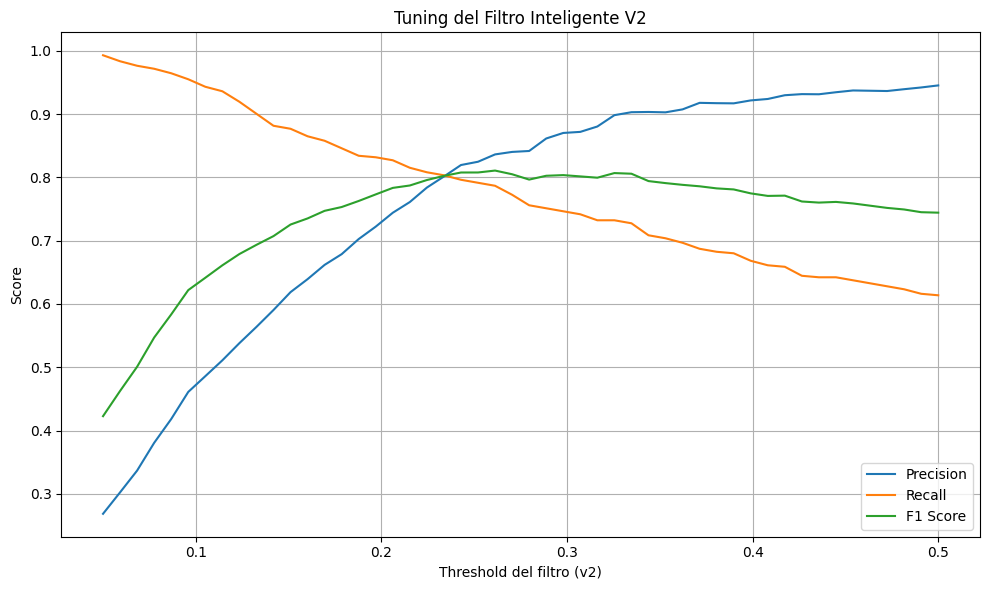


✅ Threshold óptimo final: 0.261
📋 Evaluación del modelo final + filtro v2:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     11389
           1       0.84      0.79      0.81       422

    accuracy                           0.99     11811
   macro avg       0.91      0.89      0.90     11811
weighted avg       0.99      0.99      0.99     11811

Matriz de confusión:
[[11324    65]
 [   90   332]]
Recall: 0.7867298578199052
Precision: 0.836272040302267
F1: 0.8107448107448108


In [15]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

# ───────────────────────────────────────────────
# 1. Preparar features para el filtro inteligente
# ───────────────────────────────────────────────

# Asegurar índices consistentes
X_test_reset = X_test.reset_index(drop=True)
y_test_reset = y_test.reset_index(drop=True)
y_pred_corrected = y_pred_corrected.reset_index(drop=True)

# Máscara de predicciones positivas
predicted_positive_mask = y_pred_corrected == 1

# Subset de ejemplos predichos como positivos
X_pred_pos = X_test_reset.loc[predicted_positive_mask].copy()
y_pred_pos_true = y_test_reset[predicted_positive_mask]

# Crear features del filtro
X_pos_features = X_pred_pos.copy()
X_pos_features['model_proba'] = y_proba[predicted_positive_mask]

# Flags FN
flags_aligned = fn_flags_test.reset_index(drop=True).loc[predicted_positive_mask].reset_index(drop=True)
X_pos_features['Flag_FN_Combo'] = flags_aligned['Flag_FN_Combo']

# Agregar features manuales
for col in ['TransactionAmt', 'C1', 'C4', 'DeviceType', 'card4', 'TransactionDT']:
    if col in X_test.columns:
        X_pos_features[col] = X_test_reset.loc[predicted_positive_mask, col]

# Extraer hora y flag de madrugada
if 'TransactionDT' in X_pos_features.columns:
    X_pos_features['Hour'] = (X_pos_features['TransactionDT'] / 3600) % 24
    X_pos_features['IsWeekend'] = X_pos_features['Hour'].between(0, 6).astype(int)

# Codificar categóricas
for col in X_pos_features.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X_pos_features[col] = le.fit_transform(X_pos_features[col].astype(str))

# ───────────────────────────────────────────────
# 2. Reentrenar modelo filtro con nuevas señales
# ───────────────────────────────────────────────

filter_model_v2 = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='auc',
    random_state=42
)

filter_model_v2.fit(X_pos_features, y_pred_pos_true)

# ───────────────────────────────────────────────
# 3. Barrido de thresholds para el filtro v2
# ───────────────────────────────────────────────

filter_proba = filter_model_v2.predict_proba(X_pos_features)[:, 1]

thresholds = np.linspace(0.05, 0.5, 50)
precisions, recalls, f1s, y_preds_all = [], [], [], []

for t in thresholds:
    keep_mask = filter_proba >= t
    y_pred_temp = y_pred_corrected.copy()
    indices_to_filter = y_pred_temp[predicted_positive_mask].index[~keep_mask]
    y_pred_temp.iloc[indices_to_filter] = 0

    precisions.append(precision_score(y_test, y_pred_temp, zero_division=0))
    recalls.append(recall_score(y_test, y_pred_temp, zero_division=0))
    f1s.append(f1_score(y_test, y_pred_temp, zero_division=0))
    y_preds_all.append(y_pred_temp)

# Graficar evolución
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1s, label='F1 Score')
plt.xlabel('Threshold del filtro (v2)')
plt.ylabel('Score')
plt.title('Tuning del Filtro Inteligente V2')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ───────────────────────────────────────────────
# 4. Evaluación final con mejor threshold
# ───────────────────────────────────────────────

best_idx = np.argmax(f1s)
best_thresh = thresholds[best_idx]
best_pred = y_preds_all[best_idx]

from sklearn.metrics import classification_report, confusion_matrix

print(f"\n✅ Threshold óptimo final: {best_thresh:.3f}")
print("📋 Evaluación del modelo final + filtro v2:")
print(classification_report(y_test, best_pred, zero_division=0))
print("Matriz de confusión:")
print(confusion_matrix(y_test, best_pred))
print("Recall:", recall_score(y_test, best_pred))
print("Precision:", precision_score(y_test, best_pred))
print("F1:", f1_score(y_test, best_pred))


In [16]:
# Usamos el mismo filter_proba ya generado de filter_model_v2

# Barrido fino para el último empujón
thresholds_fine = np.linspace(0.15, 0.25, 30)
fine_precisions, fine_recalls, fine_f1s, fine_preds = [], [], [], []

for t in thresholds_fine:
    keep_mask = filter_proba >= t
    y_pred_temp = y_pred_corrected.copy()
    indices_to_filter = y_pred_temp[predicted_positive_mask].index[~keep_mask]
    y_pred_temp.iloc[indices_to_filter] = 0

    fine_precisions.append(precision_score(y_test, y_pred_temp, zero_division=0))
    fine_recalls.append(recall_score(y_test, y_pred_temp, zero_division=0))
    fine_f1s.append(f1_score(y_test, y_pred_temp, zero_division=0))
    fine_preds.append(y_pred_temp)

# Buscar el mejor F1 donde precision ≥ 0.70
best_idx = None
for i, p in enumerate(fine_precisions):
    if p >= 0.70:
        if best_idx is None or fine_f1s[i] > fine_f1s[best_idx]:
            best_idx = i

# Si se encontró un buen punto
if best_idx is not None:
    best_thresh_fine = thresholds_fine[best_idx]
    best_pred_fine = fine_preds[best_idx]

    print(f"\n✅ Último ajuste: threshold = {best_thresh_fine:.3f}")
    print("📋 Evaluación final (fine tuning):")
    print(classification_report(y_test, best_pred_fine, zero_division=0))
    print("Matriz de confusión:")
    print(confusion_matrix(y_test, best_pred_fine))
    print("Recall:", recall_score(y_test, best_pred_fine))
    print("Precision:", precision_score(y_test, best_pred_fine))
    print("F1:", f1_score(y_test, best_pred_fine))
else:
    print("❌ No se encontró mejor punto con precision ≥ 0.70")



✅ Último ajuste: threshold = 0.240
📋 Evaluación final (fine tuning):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     11389
           1       0.82      0.80      0.81       422

    accuracy                           0.99     11811
   macro avg       0.90      0.90      0.90     11811
weighted avg       0.99      0.99      0.99     11811

Matriz de confusión:
[[11313    76]
 [   84   338]]
Recall: 0.8009478672985783
Precision: 0.8164251207729468
F1: 0.8086124401913876


In [17]:
# after loading df, before train/test split
df['SmallAmtFlag'] = (df['TransactionAmt'] < 125).astype(int)
# pick a cutoff around the 25th percentile of your FN TransactionDT
time_cut = df['TransactionDT'].quantile(0.25)
df['EarlyTxnFlag'] = (df['TransactionDT'] < time_cut).astype(int)


df['LowAmt_EarlyTxn'] = df['SmallAmtFlag'] & df['EarlyTxnFlag']


In [18]:
# 3) Load & prepare data

# Ensure df has your engineered flags: SmallAmtFlag, EarlyTxnFlag, LowAmt_EarlyTxn, etc.

X = df.drop(columns=['isFraud'])
y = df['isFraud'].values

# Encode categorical columns
for col in X.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# 4) Impute missing
imp = SimpleImputer(strategy='median')
X_imp = imp.fit_transform(X)

# 5) Train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    X_imp, y, stratify=y, test_size=0.2, random_state=42
)

# 6) Define & fit TabNet
tabnet = TabNetClassifier(
    n_d=32, n_a=32, n_steps=5,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax'   # entmax yields sparse feature masks
)

tabnet.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_name=['train','val'],
    eval_metric=['auc'],
    max_epochs=100,
    patience=15,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

# 7) Threshold‐tune on validation for ≥80% recall
y_proba = tabnet.predict_proba(X_val)[:,1]
best_t, best_f1 = None, 0
for t in np.linspace(0.01,0.99,99):
    pred = (y_proba >= t).astype(int)
    rec = recall_score(y_val, pred, zero_division=0)
    if rec >= 0.80:
        f1 = f1_score(y_val, pred)
        if f1 > best_f1:
            best_f1, best_t = f1, t

print(f"🌟 TabNet tuned threshold: {best_t:.2f} → Recall≥0.80, F1={best_f1:.3f}")

# 8) Final evaluation
y_pred = (y_proba >= best_t).astype(int)
print("\nClassification Report:")
print(classification_report(y_val, y_pred, zero_division=0))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))
print("ROC AUC:", round(roc_auc_score(y_val, y_proba), 3))

c:\Users\imu00\OneDrive\Escritorio\fraud_detection\.venv\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.28239 | train_auc: 0.66818 | val_auc: 0.66775 |  0:00:08s
epoch 1  | loss: 0.15287 | train_auc: 0.73852 | val_auc: 0.73699 |  0:00:18s
epoch 2  | loss: 0.14285 | train_auc: 0.76731 | val_auc: 0.77349 |  0:00:27s
epoch 3  | loss: 0.13882 | train_auc: 0.77266 | val_auc: 0.77831 |  0:00:35s
epoch 4  | loss: 0.1357  | train_auc: 0.78752 | val_auc: 0.77923 |  0:00:45s
epoch 5  | loss: 0.13328 | train_auc: 0.80586 | val_auc: 0.80917 |  0:00:54s
epoch 6  | loss: 0.13581 | train_auc: 0.78725 | val_auc: 0.78403 |  0:01:03s
epoch 7  | loss: 0.13861 | train_auc: 0.7838  | val_auc: 0.7903  |  0:01:12s
epoch 8  | loss: 0.13257 | train_auc: 0.79874 | val_auc: 0.8031  |  0:01:21s
epoch 9  | loss: 0.13134 | train_auc: 0.79887 | val_auc: 0.80287 |  0:01:29s
epoch 10 | loss: 0.13198 | train_auc: 0.80177 | val_auc: 0.80128 |  0:01:37s
epoch 11 | loss: 0.1332  | train_auc: 0.80314 | val_auc: 0.80403 |  0:01:46s
epoch 12 | loss: 0.13048 | train_auc: 0.81388 | val_auc: 0.81709 |  0:01:52s

c:\Users\imu00\OneDrive\Escritorio\fraud_detection\.venv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


🌟 TabNet tuned threshold: 0.01 → Recall≥0.80, F1=0.134

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.58      0.73     11389
           1       0.07      0.89      0.13       422

    accuracy                           0.59     11811
   macro avg       0.53      0.73      0.43     11811
weighted avg       0.96      0.59      0.71     11811

Confusion Matrix:
 [[6571 4818]
 [  47  375]]
ROC AUC: 0.853
